# Imports

In [1]:
import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')

import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
import time
import copy

from minot.ClusterTools import map_tools
import pitszi

# Parameters

In [2]:
output_dir = '/Users/adam/Desktop/pitszi_Mbb/'

In [3]:
#----- Physical model parameters
redshift = 0.5
M500 = 1e15*u.Msun
RA, Dec = 30*u.deg, 55*u.deg
axis_q1, axis_q2 = 0.7, 0.8
euler_1, euler_2, euler_3 = 40*u.deg, 50*u.deg, 15*u.deg

fluct_norm = 0.5
fluct_slope = -11./3
fluct_linj = 800*u.kpc
fluct_seed = None #25252

In [4]:
#----- Instrumental parameters
# Beam smoothing
beam_FWHM = 18*u.arcsec

# Transfer function
karcsec = np.linspace(0, 1/beam_FWHM.to_value('arcsec')*10, 1000)*u.arcsec**-1
kfov = 1/(7*60)
TF = {'k':karcsec, 'TF':1-np.exp(-karcsec.to_value('arcsec-1')/kfov)}

# Mask
mask_Ntheta500 = 0.5

# Noise
noise_k = lambda k_arcsec: (1e-9 + 3e-9 * (k_arcsec*60)**-1)
noise_r = lambda r_arcsec: (1 + np.exp((r_arcsec-200)/80))
noise_seed = 24355

In [5]:
#----- Analysis parameters
# Image sampling
los_size = 1*u.Mpc
los_reso = 100*u.kpc

# Pk measurement
Nbins_pk = 30
scale_bins = 'lin'
kmin_pk = 1/(60*5)*u.arcsec**-1
kmax_pk = 1/(beam_FWHM.to('arcsec'))

method_data_deconv = False
method_w8_radial  = True
method_w8_smooth  = 20*u.arcsec
method_w8_beam    = True
method_w8_TF      = False

# MCMC
nwalkers = 100
nsteps = 200
burnin = 20
mcmc_reset = True
mcmc_run = True

# Generate mock data

In [6]:
#===== Generate a model for the cluster and its fluctuations
mock = pitszi.Model(RA=RA, Dec=Dec, redshift=redshift, M500=M500, silent=True, output_dir=output_dir)
mock.set_pressure_profile_universal_param('A10MD')
mock.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                   'Norm': fluct_norm, 
                                   'slope': fluct_slope,
                                   'Linj': fluct_linj,
                                   'Ldis': 1*u.kpc}
mock.triaxiality = {'min_to_maj_axis_ratio':axis_q1, 'int_to_maj_axis_ratio':axis_q2,
                    'euler_angle1':euler_1, 'euler_angle2':euler_2, 'euler_angle3':euler_3}

mock.map_center = SkyCoord(mock.coord.ra, mock.coord.dec, frame="icrs")
mock.map_fov    = [5, 5]*u.arcmin
mock.map_reso  = 5.0*u.arcsec
mock.los_reso  = los_reso
mock.los_size  = los_size
mock.R_truncation = mock.R500*5

mock.give_sampling_information()

===== Information relative to the grid sampling =====
   Grid size : 59 , 59 , 11
   Pixel size :      31.4     kpc ;     5.0      arcsec
   Fov size :  [   1855.0   ,   1855.0   ] kpc ; [   4.917    ,   4.917    ] arcmin
   L.o.S. resolution :        100.0     kpc
   Map center :   <SkyCoord (ICRS): (ra, dec) in deg
    (30., 55.)>
   k min/max projected :       0.003390  /  0.098305   1/arcsec
   k min/max projected :       0.000539  /  0.015633   1/kpc
   k min/max L.o.S. (eq.) :    0.005717  /  0.028583   1/arcsec
   k min/max L.o.S. :          0.000909  /  0.004545   1/kpc
   k max Nyquist :             0.028583   1/arcsec
   k max Nyquist :             0.004545   1/kpc


In [7]:
#===== Initiate a data object and fake data
#----- init with 
data = pitszi.Data(np.zeros((1,1)), '')
data.output_dir = output_dir

#----- set basic IRFs
data.psf_fwhm              = beam_FWHM
data.transfer_function     = TF
data.noise_model = [noise_r, noise_k]

#----- Mock the data
img = data.set_image_to_mock(mock, 
                             model_seed=fluct_seed, model_no_fluctuations=False, use_model_header=True, 
                             noise_origin='model', noise_center=mock.map_center, noise_seed=noise_seed)

#----- Get noise properties
data.noise_rms = np.std(data.get_noise_monte_carlo_from_model(Nmc=1000, seed=noise_seed), axis=0)

#----- Define the mask
ramap, decmap = map_tools.get_radec_map(data.header)
dist_map = map_tools.greatcircle(ramap, decmap, data.header['CRVAL1'], data.header['CRVAL2'])
mask = dist_map * 0 + 1
mask[dist_map > mask_Ntheta500*mock.theta500.to_value('deg')] = 0 

data.mask = mask

#----- Get MC noise realizations
noise_mc = data.get_noise_monte_carlo_from_model(center=mock.coord, Nmc=1000, seed=noise_seed)

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  


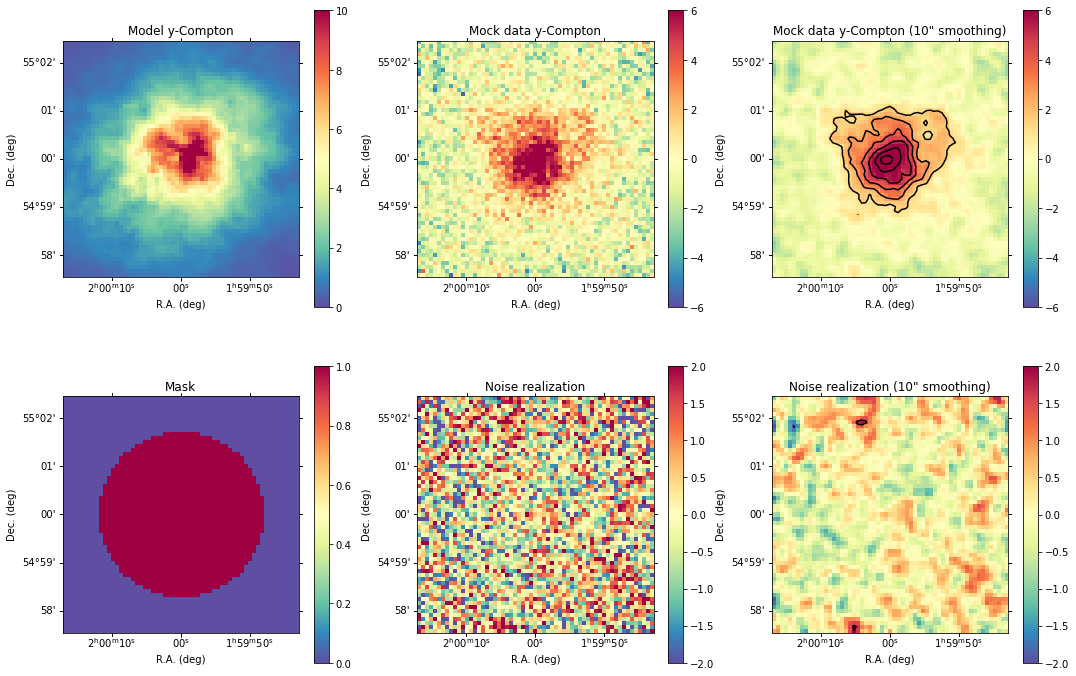

In [8]:
visu_smooth = 10

#===== Show the data
plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(18, 12))

ax = plt.subplot(2, 3, 1, projection=WCS(data.header))
plt.imshow(mock.get_sz_map(seed=fluct_seed, no_fluctuations=False)*1e5, cmap='Spectral_r', vmin=0, vmax=10)
cb = plt.colorbar()
plt.title('Model y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 2, projection=WCS(data.header))
plt.imshow(data.image*1e5, cmap='Spectral_r',vmin=-6, vmax=6)
cb = plt.colorbar()
plt.title('Mock data y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 3, projection=WCS(data.header))
plt.imshow(gaussian_filter(data.image, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)*1e5, cmap='Spectral_r', vmin=-6, vmax=6)
cb = plt.colorbar()
rms = np.std(gaussian_filter(noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(data.image, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)/rms, levels=[3,6,9,12,15,18,21], colors='k')
plt.title('Mock data y-Compton ('+str(int(visu_smooth))+'" smoothing)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 4, projection=WCS(data.header))
plt.imshow(data.mask, cmap='Spectral_r', vmin=0, vmax=1)
cb = plt.colorbar()
plt.title('Mask')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 5, projection=WCS(data.header))
plt.imshow(noise_mc[0]*1e5, cmap='Spectral_r', vmin=-2, vmax=2)
cb = plt.colorbar()
plt.title('Noise realization')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 6, projection=WCS(data.header))
plt.imshow(gaussian_filter(noise_mc[0], sigma=visu_smooth/2.35/data.header['CDELT2']/3600)*1e5, cmap='Spectral_r', vmin=-2, vmax=2)
cb = plt.colorbar()
rms = np.std(gaussian_filter(noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(noise_mc[0], sigma=visu_smooth/2.35/data.header['CDELT2']/3600)/rms, levels=[-3,3], colors='k')
plt.title('Noise realization ('+str(int(visu_smooth))+'" smoothing)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

# Build model to be used in the fit

In [9]:
model = copy.deepcopy(mock)

In [10]:
inference = pitszi.Inference(data, model)

inference.kbin_min   = kmin_pk
inference.kbin_max   = kmax_pk
inference.kbin_Nbin  = Nbins_pk
inference.kbin_scale = scale_bins

inference.mcmc_nwalkers = nwalkers
inference.mcmc_nsteps   = nsteps
inference.mcmc_burnin   = burnin
inference.mcmc_reset    = mcmc_reset
inference.mcmc_run      = mcmc_run
inference.output_dir    = output_dir

inference.method_data_deconv = method_data_deconv
inference.set_method_w8(apply_radial_model=method_w8_radial, 
                        conv_radial_model_beam=method_w8_beam, conv_radial_model_TF=method_w8_TF, 
                        remove_GNFW_core=True, 
                        smooth_FWHM=method_w8_smooth)

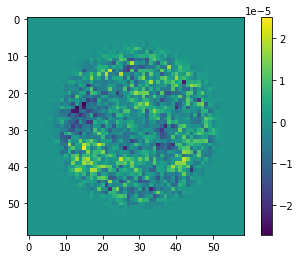

In [11]:
_,_,img,_,_ = inference.get_pk2d_data(output_ymodel=True)
plt.imshow(img)
plt.colorbar()

In [12]:
fitpar_pk3d = {
    'Norm':{'guess':[0.5, 0.5],'unit': None,'limit':[0, 3]}, #'prior':[0.5, 0.2],},
    #'slope':{'guess':[-11/3, 0.5],'unit': None,'limit':[-11/3-2, -11/3+2]}, #, #'prior':[-11/3, 0.5],},
    #'Linj':{'guess':[800, 500],'unit': u.kpc,'limit':[100, 3000]}, #, 'prior':[600, 300],               
              }
fitpar_noise = {'ampli':{'guess':[1, 0.2],'unit': None,'limit':[0, 2]}}

In [13]:
from scipy.optimize import curve_fit

k_mod, pk_mod, pk_mod_cov = inference.get_pk2d_modelvar_statistics(Nmc=100)
k_noi, pk_noi, pk_noi_cov = inference.get_pk2d_noise_statistics(Nmc=100)
k_dat, pk_dat = inference.get_pk2d_data()

def fitfunc(x, par1, par2, par3):
    inference.model.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                                  'Norm': fluct_norm*par1, 
                                                  'slope': fluct_slope,
                                                  'Linj': fluct_linj*par2,
                                                  'Ldis': 1*u.kpc}
    k_test, pk_test = inference.modelpred_fluct_deproj_forward(physical=False)
    return pk_test.to_value('arcsec2') + par3*pk_noi.to_value('arcsec2')

popt, pcov = curve_fit(fitfunc, 0, pk_dat.to_value('arcsec2'),
                       p0=[1,1,1], sigma=(np.diag(pk_noi_cov)**0.5).to_value('arcsec2'))

----- Computing Pk2d model covariance -----
----- Minimal bin counts: 4.0
----- Counts in each k bin: [ 8.  4.  8.  8.  8. 12. 20. 12. 16. 24. 16. 24. 24. 28. 28. 20. 32. 40.
 24. 44. 36. 44. 28. 44. 40. 64. 24. 68. 44. 52.]
----- Computing Pk2d noise covariance -----
----- Minimal bin counts: 4.0
----- Counts in each k bin: [ 8.  4.  8.  8.  8. 12. 20. 12. 16. 24. 16. 24. 24. 28. 28. 20. 32. 40.
 24. 44. 36. 44. 28. 44. 40. 64. 24. 68. 44. 52.]


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  


[0.86922973 0.7443972  0.99220812]
[0.08383753 0.0745048  0.08431295]
[[ 1.         -0.83662399 -0.36106329]
 [-0.83662399  1.          0.18321682]
 [-0.36106329  0.18321682  1.        ]]


(1.0803659252583385e-10, 1.6205488878875075e-08)

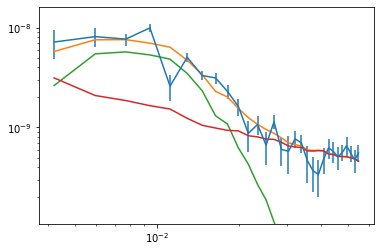

In [14]:
print(popt)
print(np.diag(pcov)**0.5)
print(pitszi.utils.correlation_from_covariance(pcov))
inference.model.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                              'Norm': fluct_norm*popt[0], 
                                              'slope': fluct_slope,
                                              'Linj': fluct_linj*popt[1],
                                              'Ldis': 1*u.kpc}
k_best, pk_best = inference.modelpred_fluct_deproj_forward(physical=False)

plt.errorbar(k_dat.value, pk_dat.value, np.diag(pk_noi_cov.value)**0.5)
plt.loglog(k_best, pk_best + popt[2]*pk_noi)
plt.loglog(k_best, pk_best)
plt.loglog(k_best, popt[2]*pk_noi)
plt.ylim(np.amax(pk_dat.value+np.diag(pk_noi_cov.value)**0.5)*1e-2, 
         np.amax(pk_dat.value+np.diag(pk_noi_cov.value)**0.5)*1.5)

# Fit the fluctuation parameters: deprojection

In [12]:
fitpar, sampler = inference.fit_fluct_deproj_forward(fitpar_pk3d,
                                                     parinfo_noise=fitpar_noise, 
                                                     Nmc_noise=100,
                                                     use_covmat=False)

----- Existing sampler:
      /Users/adam/Desktop/pitszi_Mbb//pitszi_MCMC_fluctuation_sampler.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'ampli']
      - Starting point mean:          
[0.5 1. ]
      - Starting point dispersion :   
[0.5 0.2]
      - Minimal starting point:       
[0 0]
      - Maximal starting point:       
[3 2]
      - Number of dimensions:         
2
----- Computing Pk2d noise covariance -----
----- Minimal bin counts: 4.0
----- Counts in each k bin: [ 8.  4. 12. 20. 16. 28. 20. 28. 40. 36.]


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  


----- Does the sampler already exist? -----
      - Yes, but reset the MCMC even though the sampler already exists
----- MCMC sampling -----
      - Runing 200 MCMC steps


100%|██████████| 200/200 [1:39:19<00:00, 29.80s/it]


In [14]:
inference.get_mcmc_chains_outputs_results(fitpar, sampler, extraname='_Pk_deproj')

param 0 (Norm): 
   median   = 1.2723696996128573 -0.8868973172644598 +1.0176669336115909
   best-fit = 0.08087354594129703 --0.3045988364071005 +2.209163087283151
   Norm = 1.2723696996128573_{-0.8868973172644598}^{1.0176669336115909}
param 1 (ampli): 
   median   = 1.0504956007165602 -0.7019013354812975 +0.6466806779301248
   best-fit = 0.4381091524603824 -0.08951488722511963 +1.2590671261863027
   ampli = 1.0504956007165602_{-0.7019013354812975}^{0.6466806779301248}


# Fit the fluctuation parameters: brute force